In [33]:
import os
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, Flatten, Dropout
from keras.api.optimizers import SGD
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix

In [27]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "latest_model.keras"

# Using default sort from VSCode
# Colon polyps, Colorectal cancer, Normal mucosa...
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [4]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME)
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e


In [31]:
def make_confusion_matrix(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])
        
    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

In [6]:
(train_ds, val_ds) = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/Gastrovision",
    validation_split=0.2,
    subset="both",
    seed=69420,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2426 files belonging to 3 classes.
Using 1941 files for training.
Using 485 files for validation.


I0000 00:00:1727078729.851503   34274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727078729.880620   34274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727078729.880690   34274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727078729.883012   34274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727078729.883098   34274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [26]:
for (x, y) in train_ds:
    print(y)

tf.Tensor([2 0 2 0 0 2 2 2 2 2 0 0 0 2 2 2 2 2 2 1 0 2 2 2 2 2 2 2 1 0 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 2 0 2 2 0 2 2 2 2 0 0 2 0 2 0 2 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2], shape=(32,), dtype=int32)
tf.Tensor([0 2 0 2 2 2 1 0 1 2 2 0 0 2 2 2 2 0 2 2 1 2 2 0 1 2 1 1 2 2 0 0], shape=(32,), dtype=int32)
tf.Tensor([2 2 2 2 0 0 1 2 0 2 1 1 0 2 2 2 0 2 2 0 2 2 2 0 2 0 2 2 2 1 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 0 0 2 0 2 2 2 2 2 2 0 2 2 2 0 0 0 2 2 2 0 0 0 2 2 2 2 0 2 0 2], shape=(32,), dtype=int32)
tf.Tensor([0 2 2 0 2 2 2 0 2 0 2 2 2 2 2 0 0 0 0 2 0 2 2 0 2 2 2 0 2 0 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 2 0 0 2 0 2 2 2 0 2 2 2 0 0 0 2 0 0 2 0 0 0 2 2 2 0 2 0 2 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 2 1 0 2 0 2 2 2 0 0 2 2 2 2 2 0 2 0 2 0 2 0 2 0 0 2 0 2 2 2 1], shape=(32,), dtype=int32)
tf.Tensor([0 2 0 0 2 2 2 0 2 0 0 0 0 2 2 2 0 2 2 2 0 0 1 2 2 0 0 2 0 0 2 2], shape=(32,), dtype=int32)
tf.Tensor([2 0 2 2 2 2 0 0 0 2 0 2 0 2 2 2 0 0 0 0 0 2 1 0 2 2 2 2 2 2 2 

In [7]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip()
    ])
}

In [8]:
densenet_model = keras.applications.DenseNet169(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

In [9]:
densenet_model.trainable = True

for layer in densenet_model.layers[:-4]:
    layer.trainable = False

In [10]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.densenet.preprocess_input(x)
x = densenet_model(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    20,873,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,517,123 (127.86 MB)

 Trainable params: 20,914,435 (79.78 MB)

 Non-trainable params: 12,602,688 (48.08 MB)

In [11]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [12]:
model.compile(
    optimizer=SGD(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [13]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=30, callbacks=[get_early_stopping()])

Epoch 1/30


2024-09-23 15:05:59.167616: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1727078759.223021   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.291377   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.328707   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.361744   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.394484   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.434929   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.534521   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078759.546058   37037 gpu_t

 1/61 ━━━━━━━━━━━━━━━━━━━━ 22:53 23s/step - accuracy: 0.2812 - loss: 2.8686

W0000 00:00:1727078764.865564   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.868448   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.870407   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.871939   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.873961   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.876677   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.878356   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.879904   37037 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078764.881432   37037 gp

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5764 - loss: 5.4392

W0000 00:00:1727078782.030472   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.033657   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.036717   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.040299   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.043874   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.049200   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.055824   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.061621   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078782.068330   37038 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5772 - loss: 5.4230

W0000 00:00:1727078786.540182   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.542306   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.544387   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.566368   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.568414   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.570554   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.572843   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.574941   37038 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727078786.576831   37038 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - accuracy: 0.5780 - loss: 5.4074 - val_accuracy: 0.7320 - val_loss: 2.2756
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 359ms/step - accuracy: 0.7146 - loss: 2.6137 - val_accuracy: 0.5485 - val_loss: 3.8920
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.7549 - loss: 1.8465 - val_accuracy: 0.4928 - val_loss: 4.3522
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.7436 - loss: 1.7700 - val_accuracy: 0.7278 - val_loss: 1.6511
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7664 - loss: 1.3583 - val_accuracy: 0.7546 - val_loss: 1.1577
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7489 - loss: 1.3900 - val_accuracy: 0.7196 - val_loss: 1.3768
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 358ms/step - accuracy: 0.7855 - loss: 0.9897 - val_accuracy: 0.4722 - val_loss: 3.6476
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.7669 - loss: 1.1468 - val_accuracy: 0.812

In [25]:
save_model(model, "densenet169_default_dataset_")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


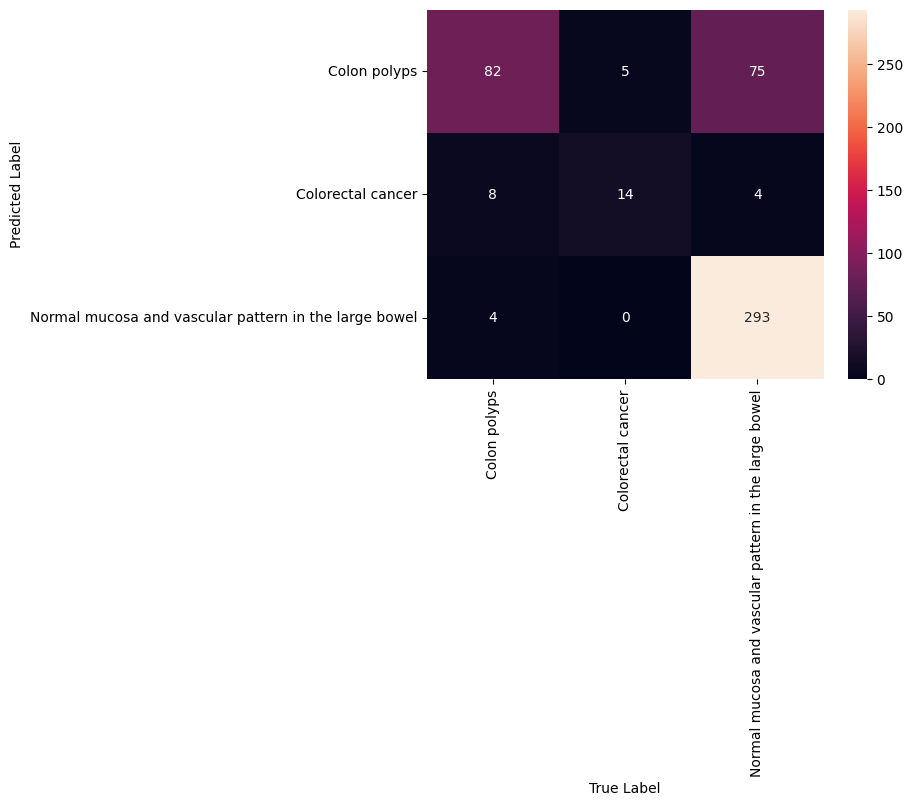

In [34]:
make_confusion_matrix(model, val_ds)